In [1]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2
import random
import sys
import os

import sys
import os

# Get the absolute path of the src folder
sys.path.append(os.path.abspath("src"))


from utils import show_image, preprocess_image, clip_eps, get_label
from watermark import generate_adversaries_targeted, perturb_image, verify_watermark

2025-02-16 17:17:35.342101: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-16 17:17:35.342138: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-16 17:17:35.343896: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-16 17:17:35.356252: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
EPS = 2./255
IMAGENET_LABELS = "./data/imagenet_class_index.json"

with open(IMAGENET_LABELS) as f:
    IMAGENET_CLASSES = {int(i):x[1] for i,x in json.load(f).items()}

In [3]:
k = 4
secret_labels = random.sample(range(1000), k)
print("Secret labels:", secret_labels)
print("Secret label names:", [IMAGENET_CLASSES[label] for label in secret_labels])

Secret labels: [232, 243, 783, 493]
Secret label names: ['Border_collie', 'bull_mastiff', 'screw', 'chiffonier']


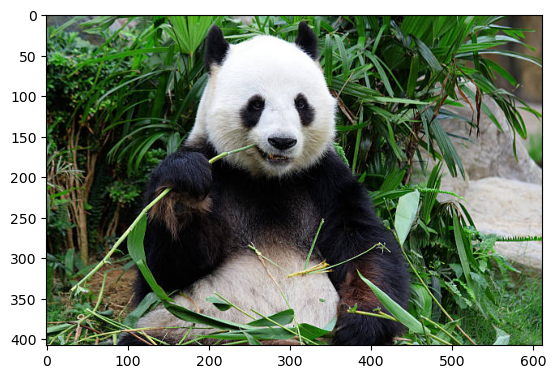

2025-02-16 17:17:38.542308: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9804 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:44:00.0, compute capability: 7.5


In [4]:
sample_image = show_image("./data/imagenet/giant_panda/giantpanda.jpg")
preprocessed_image = preprocess_image(sample_image, preprocess=True)
resnet50 = tf.keras.applications.ResNet50(weights="imagenet", include_top=True, classifier_activation=None)

In [5]:
preds = resnet50.predict(preprocessed_image)
print("Logits:", decode_predictions(preds, top=3)[0])
print("Class idx:", preds.argmax())

2025-02-16 17:17:41.711518: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


1/1 [==============================] - 2s 2s/step
Logits: [('n02510455', 'giant_panda', 17.56317), ('n02509815', 'lesser_panda', 10.0991535), ('n02488702', 'colobus', 9.428916)]
Class idx: 388


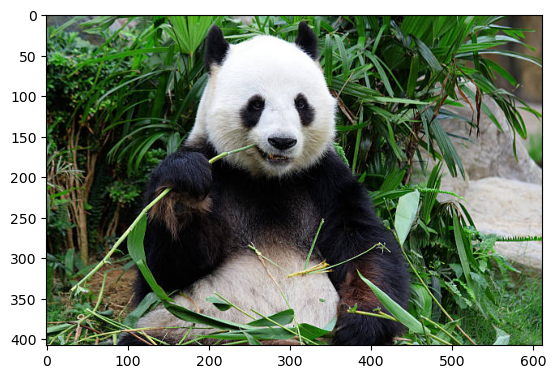

Preprocessed image saved at: ./output/preprocessed_image.png
1/1 [==============================] - 0s 36ms/step
Logits before adv.: [('n02510455', 'giant_panda', 17.55588), ('n02509815', 'lesser_panda', 10.108609), ('n02488702', 'colobus', 9.493951)]

Predictions for secret labels BEFORE perturbation:
Label: Border_collie (Index: 232), Logit: 5.02764892578125
Label: bull_mastiff (Index: 243), Logit: -0.08549178391695023
Label: screw (Index: 783), Logit: -0.8750722408294678
Label: chiffonier (Index: 493), Logit: -3.3333890438079834
Iteration 0, Loss: 69.49642181396484


2025-02-16 17:17:44.409939: I external/local_xla/xla/service/service.cc:168] XLA service 0x5592ee343d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-16 17:17:44.409966: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-02-16 17:17:44.416583: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739755064.603866    4564 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Iteration 20, Loss: 50.103816986083984
Iteration 40, Loss: 38.636409759521484
Iteration 60, Loss: 33.86389923095703
Iteration 80, Loss: 32.72757339477539
Iteration 100, Loss: 32.22414779663086
Iteration 120, Loss: 31.830116271972656
Iteration 140, Loss: 31.39966583251953
Iteration 160, Loss: 30.978065490722656
Iteration 180, Loss: 30.588546752929688
Iteration 200, Loss: 30.213787078857422
Iteration 220, Loss: 29.83580207824707
Iteration 240, Loss: 29.447101593017578
Iteration 260, Loss: 29.060802459716797
Iteration 280, Loss: 28.655107498168945
Iteration 300, Loss: 28.214685440063477
Iteration 320, Loss: 27.73892593383789
Iteration 340, Loss: 27.2418155670166


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


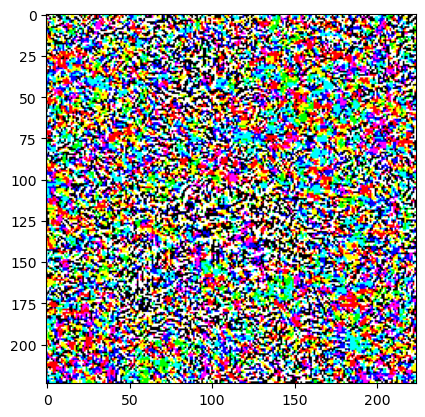

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


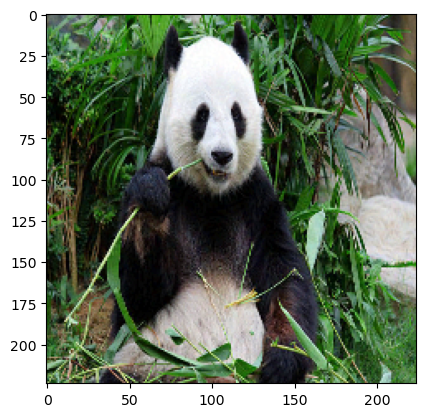

1/1 [==============================] - 0s 37ms/step
Logits after adv.: [('n02510455', 'giant_panda', 5.3656507), ('n02106166', 'Border_collie', 5.191498), ('n02106030', 'collie', 4.22171)]

Predictions for secret labels:
Label: Border_collie (Index: 232), Logit: 5.191497802734375
Label: bull_mastiff (Index: 243), Logit: 1.218470573425293
Label: screw (Index: 783), Logit: 1.3250946998596191
Label: chiffonier (Index: 493), Logit: -0.47982871532440186
 Label: 232 , logit_diff : 0.163848876953125
 Label: 243 , logit_diff : 1.3039623498916626
 Label: 783 , logit_diff : 2.200166940689087
 Label: 493 , logit_diff : 2.853560447692871
Watermark verified!


In [6]:
#@title Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)
perturb_image("./examples/panda.jpg", 388, secret_labels, resnet50, optimizer,EPS)